# Named Entity Recognition task using RoBERTa
## Test 6

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Numero di frasi nel training set: 765
Numero di frasi nel test set: 200
Lunghezza media delle frasi nel training set: 26.18
Lunghezza media delle frasi nel test set: 26.29


<ipython-input-5-a957d81c6fce>:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(tag_counts.keys()), y=list(tag_counts.values()), palette="viridis")


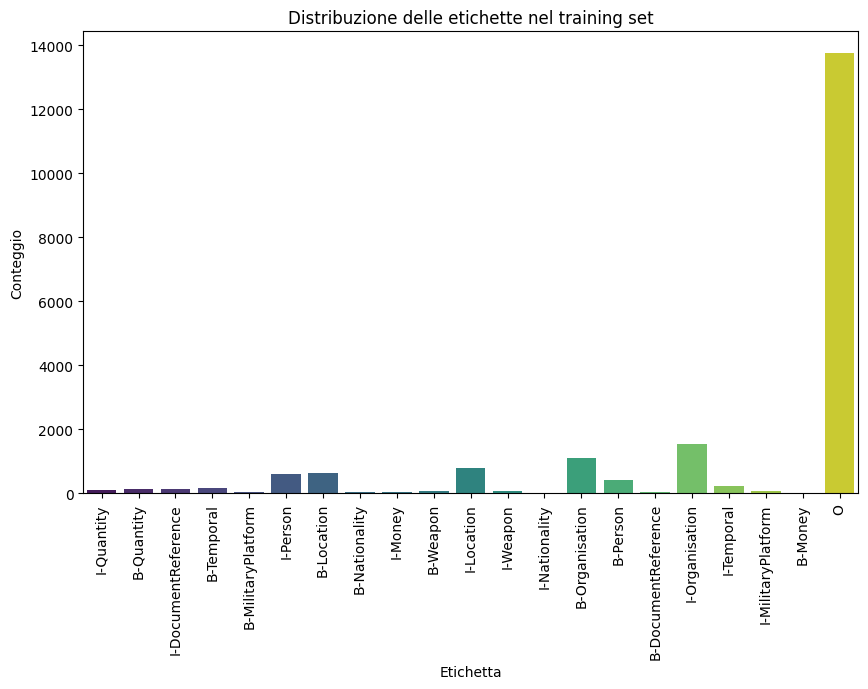

Distribuzione delle frequenze delle classi nel training set: [   94   150   146   177    47   605   644    34    36    81   784    70
     2  1104   411    50  1539   225    64    20 13747]


<ipython-input-5-a957d81c6fce>:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(tag_counts.keys()), y=list(tag_counts.values()), palette="viridis")


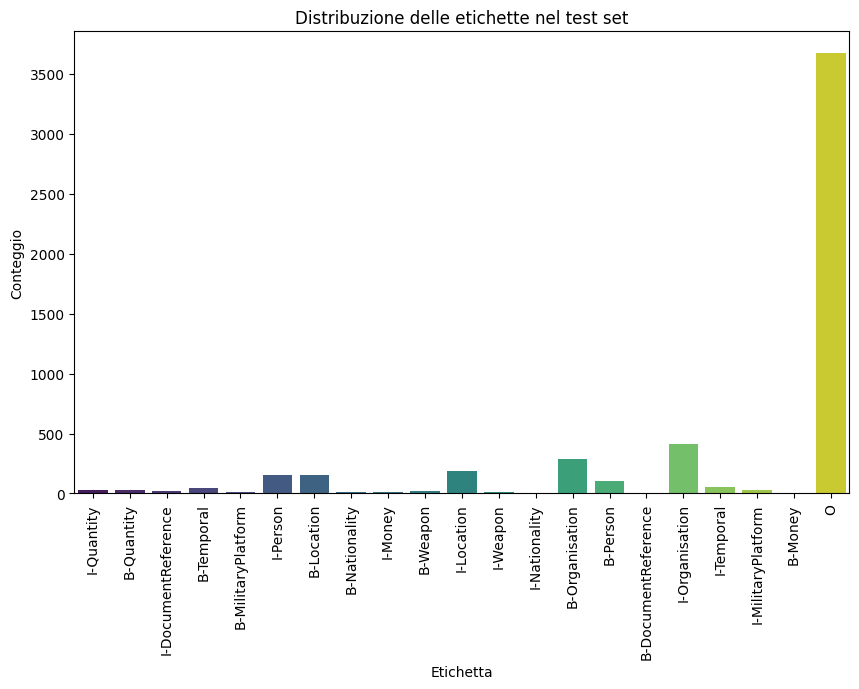

Distribuzione delle frequenze delle classi nel test set: [  32   30   20   46   16  150  155   10    9   17  191   14    2  284
  106    8  411   55   26    4 3672]


<ipython-input-5-a957d81c6fce>:174: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(augmented_tag_counts.keys()), y=list(augmented_tag_counts.values()), palette="viridis")


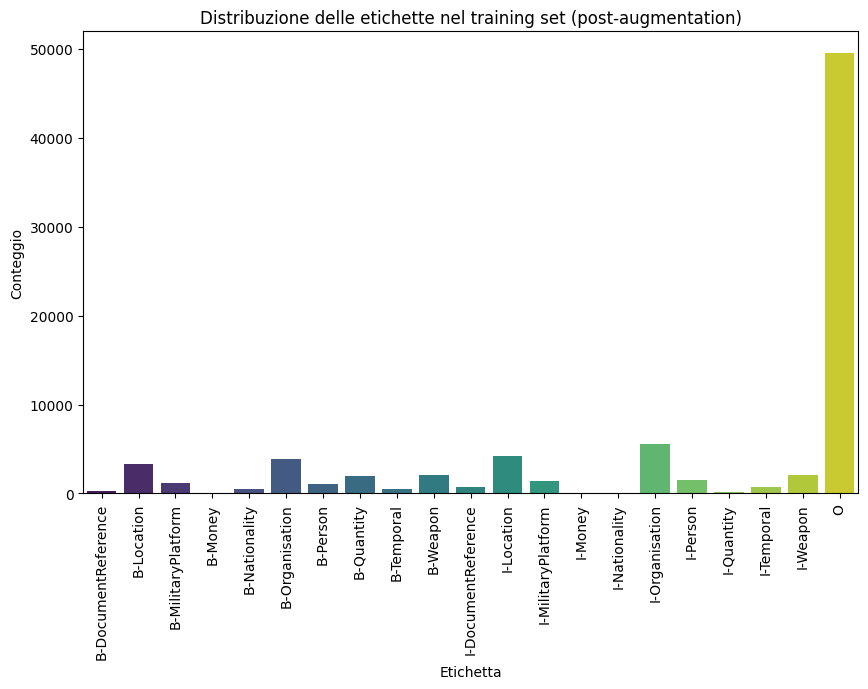

Distribuzione delle frequenze delle classi nel training set (post-augmentation): [  266  3284  1199    56   526  3888  1035  2010   549  2085   674  4204
  1420    60    50  5619  1493   214   681  2098 49483]


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/2589 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


<ipython-input-5-a957d81c6fce>:265: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.882100,0.463157,0.529217,0.710059,0.606443,0.861925
2,0.713400,0.347880,0.630221,0.758876,0.688591,0.886839
3,0.589600,0.330677,0.643735,0.775148,0.703356,0.897870
4,0.465700,0.353273,0.653753,0.798817,0.719041,0.894827
5,0.391600,0.350853,0.652934,0.773669,0.708192,0.900152
6,0.401800,0.347232,0.659548,0.776627,0.713315,0.899772
7,0.278800,0.367804,0.667500,0.789941,0.723577,0.900342
8,0.238900,0.376691,0.680255,0.789941,0.731006,0.901674
9,0.252000,0.383320,0.673367,0.792899,0.728261,0.899582


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.3766905665397644, 'eval_precision': 0.6802547770700637, 'eval_recall': 0.7899408284023669, 'eval_f1': 0.7310061601642711, 'eval_accuracy': 0.9016736401673641, 'eval_runtime': 0.387, 'eval_samples_per_second': 516.734, 'eval_steps_per_second': 33.588, 'epoch': 9.0}


In [ ]:
!pip install transformers datasets seqeval scikit-learn nlpaug evaluate -q

import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
from sklearn.utils.class_weight import compute_class_weight
from evaluate import load
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.sentence as nas
!pip install nltk -q
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
!pip install nlpaug --upgrade


# Function to load CoNLL file
def load_conll_file(filepath):
    """
    Loads a CoNLL file containing tokenized sentences with corresponding tags.

    Args:
        filepath: Path to the CoNLL file.

    Returns:
        sentences: List of tokenized sentences.
        tags: List of corresponding tag sequences.
    """
    sentences = []
    tags = []
    with open(filepath, "r") as file:
        sentence = []
        tag_sequence = []
        for line in file:
            line = line.strip()
            if not line:  # End of sentence
                if sentence:
                    sentences.append(sentence)
                    tags.append(tag_sequence)
                sentence = []
                tag_sequence = []
            else:
                token, tag = line.split()[:2]  # Token and Tag
                sentence.append(token)
                tag_sequence.append(tag)
        if sentence:  # Add the last sentence
            sentences.append(sentence)
            tags.append(tag_sequence)
    return sentences, tags


train_sentences, train_tags = load_conll_file("/content/re3d-train.conll")
test_sentences, test_tags = load_conll_file("/content/re3d-test.conll")


# Dataset preparation
unique_tags = sorted(set(tag for tags in train_tags for tag in tags))
tag2id = {tag: i for i, tag in enumerate(unique_tags)}
id2tag = {i: tag for tag, i in tag2id.items()}


def encode_tags(tags, tag2id):
    """
    Converts tags to their corresponding integer IDs using a provided mapping.

    Args:
        tags: List of tag sequences.
        tag2id: Mapping from tag to tag ID.

    Returns:
        encoded_tags: List of encoded tag sequences.
    """
    return [[tag2id[tag] for tag in sentence_tags] for sentence_tags in tags]


train_tag_ids = encode_tags(train_tags, tag2id)
test_tag_ids = encode_tags(test_tags, tag2id)


# Transformation into Dataset format
train_data = [{"tokens": tokens, "tags": tags} for tokens, tags in zip(train_sentences, train_tag_ids)]
test_data = [{"tokens": tokens, "tags": tags} for tokens, tags in zip(test_sentences, test_tag_ids)]


dataset = DatasetDict({
    "train": Dataset.from_list(train_data),
    "test": Dataset.from_list(test_data),
})


# Display class distribution in the dataset


# Sentence analysis
num_train_sentences = len(train_sentences)
num_test_sentences = len(test_sentences)
avg_train_length = np.mean([len(sentence) for sentence in train_sentences])
avg_test_length = np.mean([len(sentence) for sentence in test_sentences])


print(f"Number of sentences in the training set: {num_train_sentences}")
print(f"Number of sentences in the test set: {num_test_sentences}")
print(f"Average sentence length in the training set: {avg_train_length:.2f}")
print(f"Average sentence length in the test set: {avg_test_length:.2f}")


# Class distribution in the training set
all_tags = [tag for tags in train_tags for tag in tags]
tag_counts = {tag: all_tags.count(tag) for tag in set(all_tags)}


# Show tag distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(tag_counts.keys()), y=list(tag_counts.values()), palette="viridis")
plt.xticks(rotation=90)
plt.title("Tag distribution in the training set")
plt.xlabel("Tag")
plt.ylabel("Count")
plt.show()


# Calculate class balancing
class_frequencies = np.array(list(tag_counts.values()))
print(f"Class frequencies distribution in the training set: {class_frequencies}")


# Class distribution in the test set
all_tags = [tag for tags in test_tags for tag in tags]
tag_counts = {tag: all_tags.count(tag) for tag in set(all_tags)}


# Show tag distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(tag_counts.keys()), y=list(tag_counts.values()), palette="viridis")
plt.xticks(rotation=90)
plt.title("Tag distribution in the test set")
plt.xlabel("Tag")
plt.ylabel("Count")
plt.show()


# Calculate class balancing
class_frequencies = np.array(list(tag_counts.values()))
print(f"Class frequencies distribution in the test set: {class_frequencies}")


# Data Augmentation
def augment_data(dataset, target_label, n_augment=5):
    """
    Performs advanced data augmentation for NER (without back translation).

    Args:
        dataset: The dataset to augment.
        target_label: The target label to augment.
        n_augment: Number of augmentations to generate for each example.

    Returns:
        augmented_data: The augmented dataset.
    """
    aug_synonyms = naw.SynonymAug(aug_src='wordnet', aug_p=0.3)
    aug_contextual = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', aug_p=0.2)
    aug_scramble = nac.RandomCharAug(action='swap', aug_char_min=2, aug_word_p=0.2)

    augmented_data = []
    for example in dataset:
        if target_label in example["tags"]:
            for _ in range(n_augment):
                # Apply augmentation techniques
                augmented_text_1 = aug_synonyms.augment(example["tokens"])
                augmented_text_2 = aug_contextual.augment(example["tokens"])
                augmented_text_3 = aug_scramble.augment(example["tokens"])

                augmented_data.extend([
                    {"tokens": augmented_text_1, "tags": example["tags"]},
                    {"tokens": augmented_text_2, "tags": example["tags"]},
                    {"tokens": augmented_text_3, "tags": example["tags"]},
                ])
    return augmented_data


low_freq_labels = ["B-MilitaryPlatform", "B-Nationality", "B-Weapon", "I-Nationality", "I-Weapon"]
augmented_train = []
for label in low_freq_labels:
    augmented_train += augment_data(train_data, tag2id[label], n_augment=4)


train_data += augmented_train
dataset["train"] = Dataset.from_list(train_data)


# Extract all tags from the updated training dataset
all_augmented_tags = [tag for example in dataset["train"] for tag in example["tags"]]


# Count occurrences for each tag
augmented_tag_counts = {id2tag[tag]: all_augmented_tags.count(tag) for tag in set(all_augmented_tags)}


# Show tag distribution after data augmentation
plt.figure(figsize=(10, 6))
sns.barplot(x=list(augmented_tag_counts.keys()), y=list(augmented_tag_counts.values()), palette="viridis")
plt.xticks(rotation=90)
plt.title("Tag distribution in the training set (post-augmentation)")
plt.xlabel("Tag")
plt.ylabel("Count")
plt.show()


# Display frequency distribution
augmented_class_frequencies = np.array(list(augmented_tag_counts.values()))
print(f"Class frequencies distribution in the training set (post-augmentation): {augmented_class_frequencies}")


# Tokenization and label alignment
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)


def tokenize_and_align_labels(examples):
    """
    Tokenizes input text and aligns the labels with the tokens, padding them to a fixed length.

    Args:
        examples: The input dataset to tokenize.

    Returns:
        tokenized_inputs: The tokenized inputs with aligned labels.
    """
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True, padding="max_length", max_length=128
    )
    labels = []
    for i, label in enumerate(examples["tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = []
        previous_word_id = None
        for word_id in word_ids:
            if word_id is None:
                label_ids.append(-100)  # Ignore padding
            elif word_id != previous_word_id:  # First token of the word
                label_ids.append(label[word_id])
            else:  # Additional tokens
                label_ids.append(-100)
            previous_word_id = word_id
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs


tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)


# Model and training parameters definition
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(unique_tags))
model.config.id2label = id2tag
model.config.label2id = tag2id

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=9,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_strategy="epoch",
    fp16=True
)


# Evaluation function
metric = load("seqeval")


def compute_metrics(eval_pred):
    """
    Computes metrics for evaluation: precision, recall, F1-score, and accuracy.

    Args:
        eval_pred: Predictions and true labels.

    Returns:
        metrics: Dictionary containing precision, recall, F1-score, and accuracy.
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)

    true_labels = [[id2tag[label] for label in sentence if label != -100] for sentence in labels]
    true_predictions = [[id2tag[pred] for pred, label in zip(sentence, labels[i]) if label != -100]
                        for i, sentence in enumerate(predictions)]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }


# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


# Model training
trainer.train()


# Final evaluation
results = trainer.evaluate()
print(results)


Classification Report:
                     precision    recall  f1-score   support

B-DocumentReference       1.00      0.88      0.93         8
         B-Location       0.74      0.86      0.80       155
 B-MilitaryPlatform       0.44      0.44      0.44        16
            B-Money       0.75      0.75      0.75         4
      B-Nationality       0.86      0.60      0.71        10
     B-Organisation       0.78      0.80      0.79       284
           B-Person       0.89      0.93      0.91       106
         B-Quantity       0.64      0.90      0.75        30
         B-Temporal       0.77      0.93      0.84        46
           B-Weapon       0.42      0.47      0.44        17
I-DocumentReference       0.74      0.85      0.79        20
         I-Location       0.76      0.87      0.81       191
 I-MilitaryPlatform       0.80      0.62      0.70        26
            I-Money       1.00      0.78      0.88         9
      I-Nationality       0.00      0.00      0.00         2


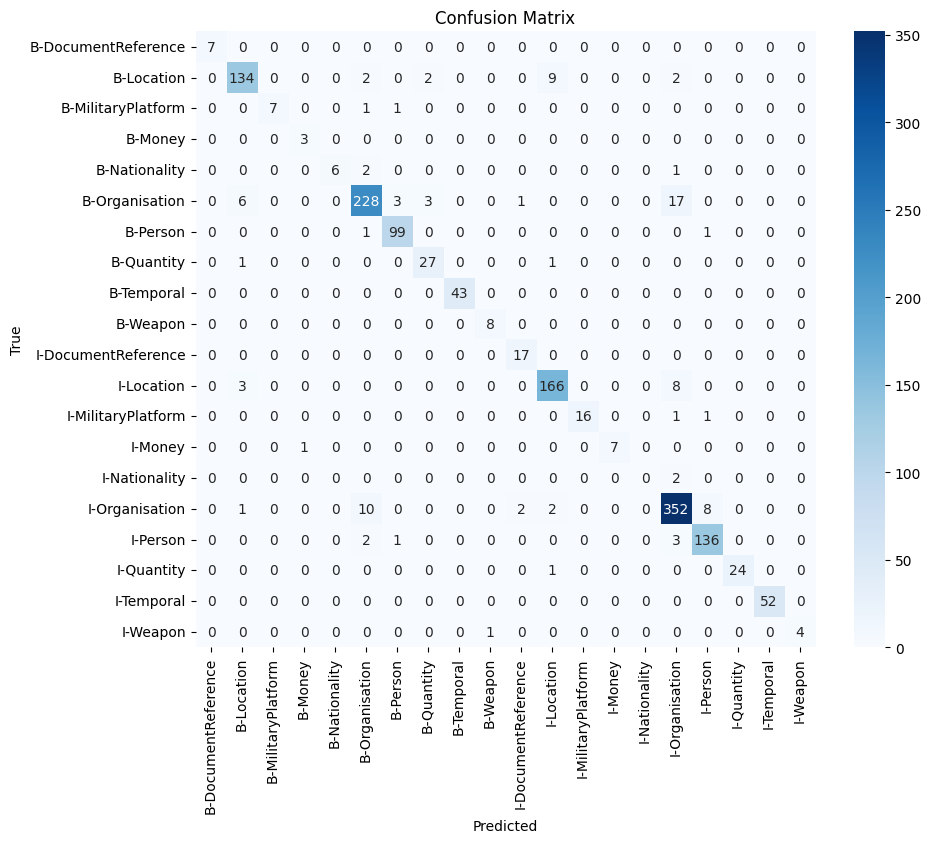

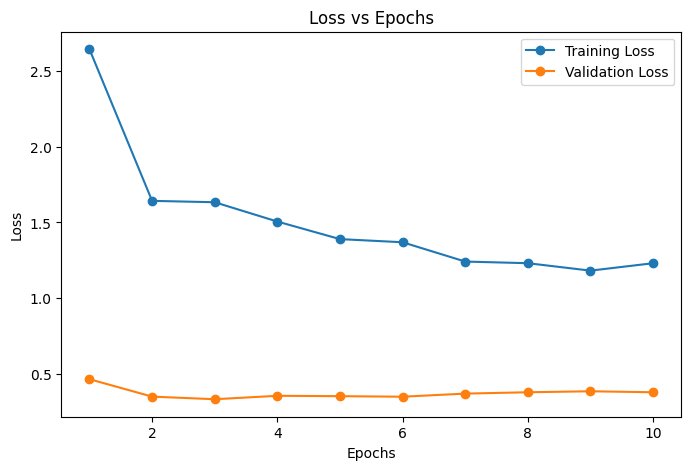

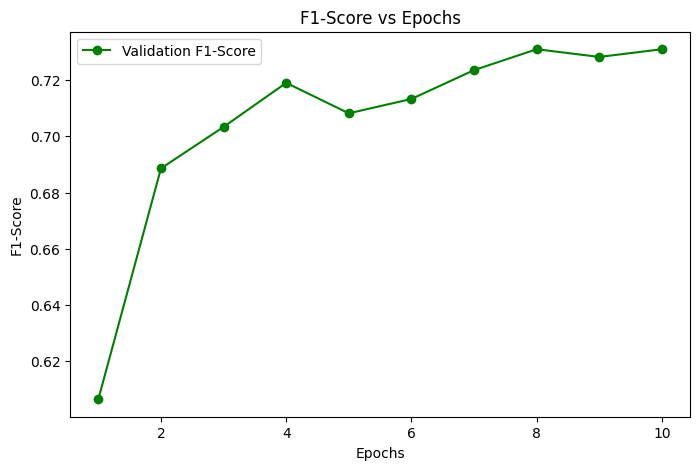

In [ ]:
def generate_classification_report(trainer, dataset, id2tag):
    """
    Generates a classification report for the model's predictions on a dataset.

    Args:
        trainer: The Hugging Face trainer object.
        dataset: The dataset on which to evaluate the model.
        id2tag: Dictionary mapping label IDs to label names.

    Returns:
        y_true: True labels for all tokens.
        y_pred: Predicted labels for all tokens.
    """
    predictions, labels, _ = trainer.predict(dataset)
    predictions = np.argmax(predictions, axis=2)

    # Align labels with tokenized input
    true_labels = [[id2tag[label] for label in sentence if label != -100] for sentence in labels]
    true_predictions = [[id2tag[pred] for pred, label in zip(sentence, labels[i]) if label != -100]
                        for i, sentence in enumerate(predictions)]

    # Flatten lists for classification report
    y_true = [label for sentence in true_labels for label in sentence]
    y_pred = [pred for sentence in true_predictions for pred in sentence]

    # Generate and print classification report
    report = classification_report(y_true, y_pred, labels=list(id2tag.values()), zero_division=0)
    print("Classification Report:")
    print(report)
    return y_true, y_pred


def plot_confusion_matrix(y_true, y_pred, classes):
    """
    Plots a confusion matrix based on true and predicted labels.

    Args:
        y_true: True labels for all tokens.
        y_pred: Predicted labels for all tokens.
        classes: List of class names for the confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


def plot_training_metrics(log_history):
    """
    Plots the training loss, validation loss, and validation F1-score over epochs.

    Args:
        log_history: The training log history containing loss and F1-score values.
    """
    train_loss = [entry["loss"] for entry in log_history if "loss" in entry]
    eval_loss = [entry["eval_loss"] for entry in log_history if "eval_loss" in entry]
    eval_f1 = [entry["eval_f1"] for entry in log_history if "eval_f1" in entry]

    # Get the number of epochs for the x-axis
    epochs = range(1, len(eval_loss) + 1) # Use len(eval_loss) to get the correct number of epochs

    # Loss plot
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_loss[:len(eval_loss)], label="Training Loss", marker="o") # Adjust train_loss to match eval_loss length
    plt.plot(epochs, eval_loss, label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs Epochs")
    plt.legend()
    plt.show()

    # F1-Score plot
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, eval_f1, label="Validation F1-Score", marker="o", color="green")
    plt.xlabel("Epochs")
    plt.ylabel("F1-Score")
    plt.title("F1-Score vs Epochs")
    plt.legend()
    plt.show()


# Generate and plot the classification report, confusion matrix, and training metrics
y_true, y_pred = generate_classification_report(trainer, tokenized_datasets["test"], id2tag)
classes = [tag for tag in unique_tags if tag != "O"]  # Exclude 'O' tag from confusion matrix
plot_confusion_matrix(y_true, y_pred, classes)
plot_training_metrics(trainer.state.log_history)